In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy import stats
import glob 
import seaborn as sns 
import ta 
plt.style.use('ggplot')

### Loading raw data

In [3]:
prices = pd.read_csv('price_rte.csv')
prices.columns = ['date', 'price']
prices['date'] = pd.to_datetime(prices['date'])
#prices.head()

In [ ]:
prod = pd.read_csv('weather.csv')
prod.drop(0, axis =0, inplace = True)
c = list(prod.columns) 
c[0] = 'date'
prod.columns = c
prod['date'] = pd.to_datetime(prod['date'])
prod.head()

### Probability parameter estimation and sampling 

In [ ]:
def sample_data(initial_df, target_col, target_year = 2015, smoothing_filter_size = 4):
    yearly_data = initial_df[initial_df['date'].dt.year == target_year]
    per_quarter_value = []
    
    for q in yearly_data['date'].dt.quarter.unique(): 
        daily_data = []
        sub_quarter = yearly_data[yearly_data['date'].dt.quarter == q]
        for m in sub_quarter['date'].dt.month.unique(): 
            sub_m = sub_quarter[sub_quarter['date'].dt.month == m]
            for w in sub_m['date'].dt.isocalendar().week.unique():
                sub_w = sub_m[sub_m['date'].dt.isocalendar().week == w]
                for d in sub_w['date'].dt.weekday.unique(): 
                    day = sub_w[sub_w['date'].dt.weekday == d]
                    daily_data.append(day[target_col].values.flatten())
        per_quarter_value.append(np.array(daily_data))
    
    quarterly_samples = []
    for q in per_quarter_value: 
    
        epsi = np.random.normal(0.,0.3, size = (7 * 13, 24))
        means = np.mean(q, axis = 0)
        stds = np.std(q, axis = 0)
        
        samples = means.reshape(1,-1) + epsi * stds.reshape(1,-1)
        smoothed_samples = np.convolve(samples.flatten(),
                                       np.ones(smoothing_filter_size,) / float(smoothing_filter_size), 
                                      mode= 'same') 
                
        quarterly_samples.append(smoothed_samples.flatten())
    return quarterly_samples

# ONE YEAR OF PROD
sampled_prod = sample_data(prod, 'wind_speed')
# ONE YEAR OF CONSUMPTION
sampled_consumption = sample_data(prices, 'price')


### Saving data

In [ ]:
prod_data = np.hstack([p.flatten() for p in sampled_prod]).reshape(-1,1)
conso_data = np.hstack([p.flatten() for p in sampled_consumption]).reshape(-1,1)
data = pd.DataFrame(np.hstack([prod_data, conso_data]),
             columns = ['prod', 'conso'])
data['date'] = pd.to_datetime(pd.date_range("2015", freq = "H", periods = len(data)))
data.to_csv('./sampled_data.csv', index = False)

### RL ENV GENERATION 

In [ ]:
data = pd.read_csv('sampled_data.csv')
data['date'] = pd.to_datetime(data['date'])

In [ ]:
look_back = 3
data = data[['date', 'prod', 'conso']]
rl_data = data[['date']]

# ADDING LOOKBACK
for i in range(look_back): 
    rl_data['prod_s{}'.format(i)] = data['prod'].shift(i)
    rl_data['conso_s{}'.format(i)] = data['conso'].shift(i)


# ADDING TRENDS 
periods = [3, 5, 10, 20]
for ip, period in enumerate(periods): 
    for col in ['prod', 'conso']: 
        indicator = ta.trend.SMAIndicator(rl_data['{}_s0'.format(col)], window = period)
        sma = indicator.sma_indicator()
        
        for c in rl_data.columns: 
            if c in ['{}_s{}'.format(col, i) for i in range(look_back)]: 
                rl_data['{}_{}n'.format(c, period)] = rl_data[c] / sma -1.
        
# ADDING NORMALIZED TIME
rl_data['hour_n'] = rl_data['date'].dt.hour / 24.
rl_data['day_n'] = rl_data['date'].dt.weekday / 6.

# ADDING UNSCALED COLS 
rl_data['conso'] = data['conso']
rl_data['prod'] = data['prod']


# CLEANING
rl_data.dropna(inplace = True)
rl_data.reset_index(drop = True, inplace = True)



# OUTPUT 
rl_data.to_csv('rl_s3same_env.csv', index = False)

# INSPECTION
rl_data.head()

### DISPLAY, TESTS, AND EXPLO STUFF (NOT REQUIRED) 

In [4]:
years = {}
for year in prices['date'].dt.year.unique(): 
    years[str(year)] = prices[prices['date'].dt.year == year]

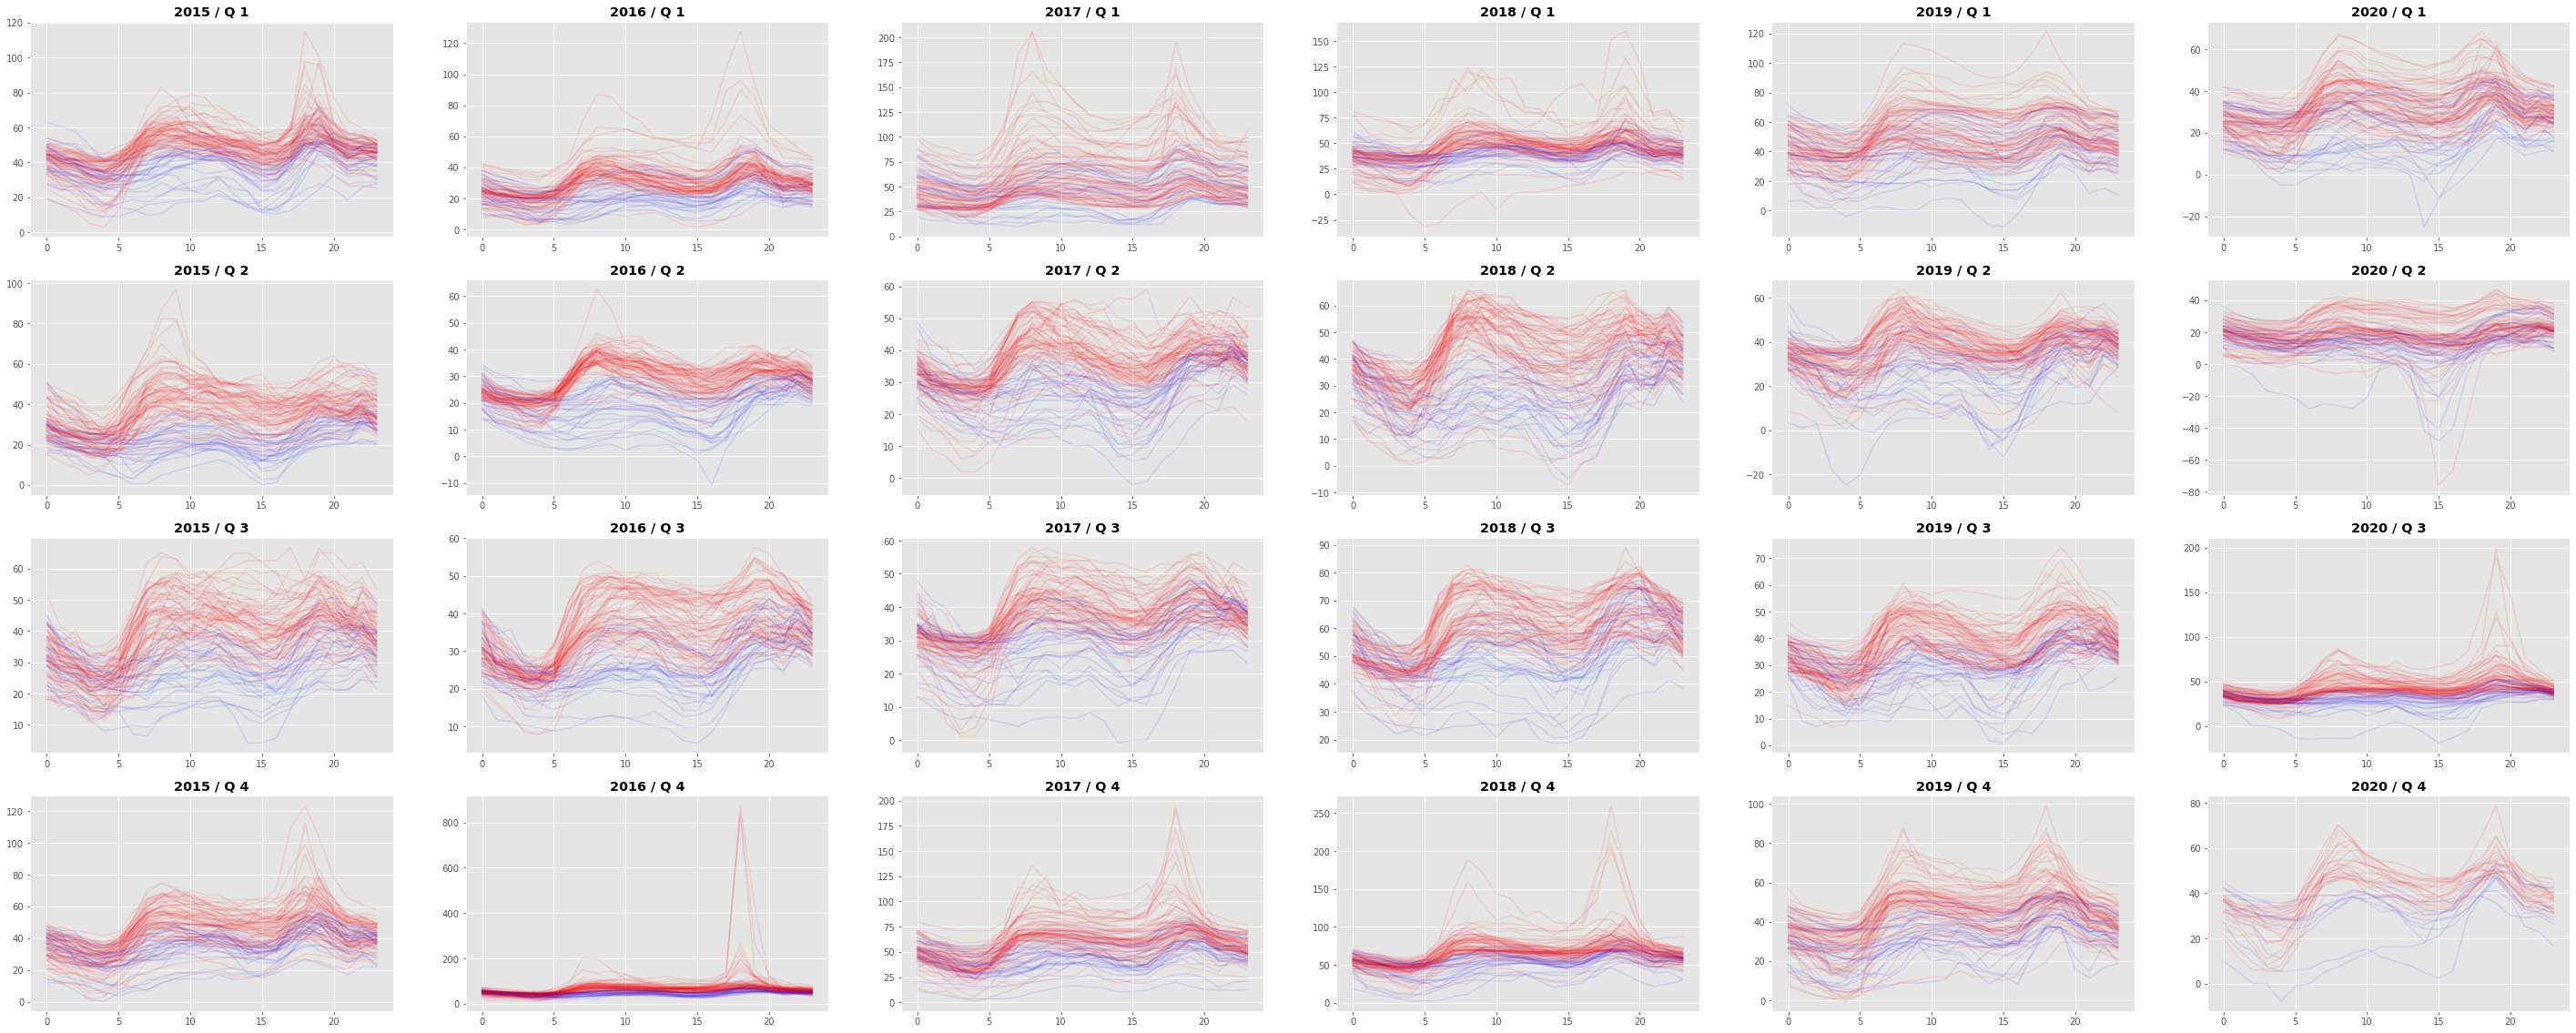

In [5]:
f, axes = plt.subplots(4,len(years.keys()), figsize = (50,20))

for i,k in enumerate(years.keys()): 
    current_year = years[k]
    for quarter in current_year['date'].dt.quarter.unique(): 
        sub_quarter = current_year[current_year['date'].dt.quarter == quarter]
        for m in sub_quarter['date'].dt.month.unique(): 
            sub_month = sub_quarter[sub_quarter['date'].dt.month == m]
            for w in sub_month['date'].dt.isocalendar().week.unique(): 
                sub_week = sub_month[sub_month['date'].dt.isocalendar().week == w]
                for d in sub_week['date'].dt.day.unique(): 
                    sub_day = sub_week[sub_week['date'].dt.day == d]
                    week_day = sub_day['date'].dt.weekday.values[1] < 5
                    ax = axes[quarter -1, i]
                    ax.plot(sub_day.price.values.flatten(), alpha = 0.1, color = 'red' if week_day else 'blue')
                    ax.set_title('{} / Q {}'.format(k, quarter), weight = 'bold')
                    
                    #days.append(sub_day.price.values.flatten())
            

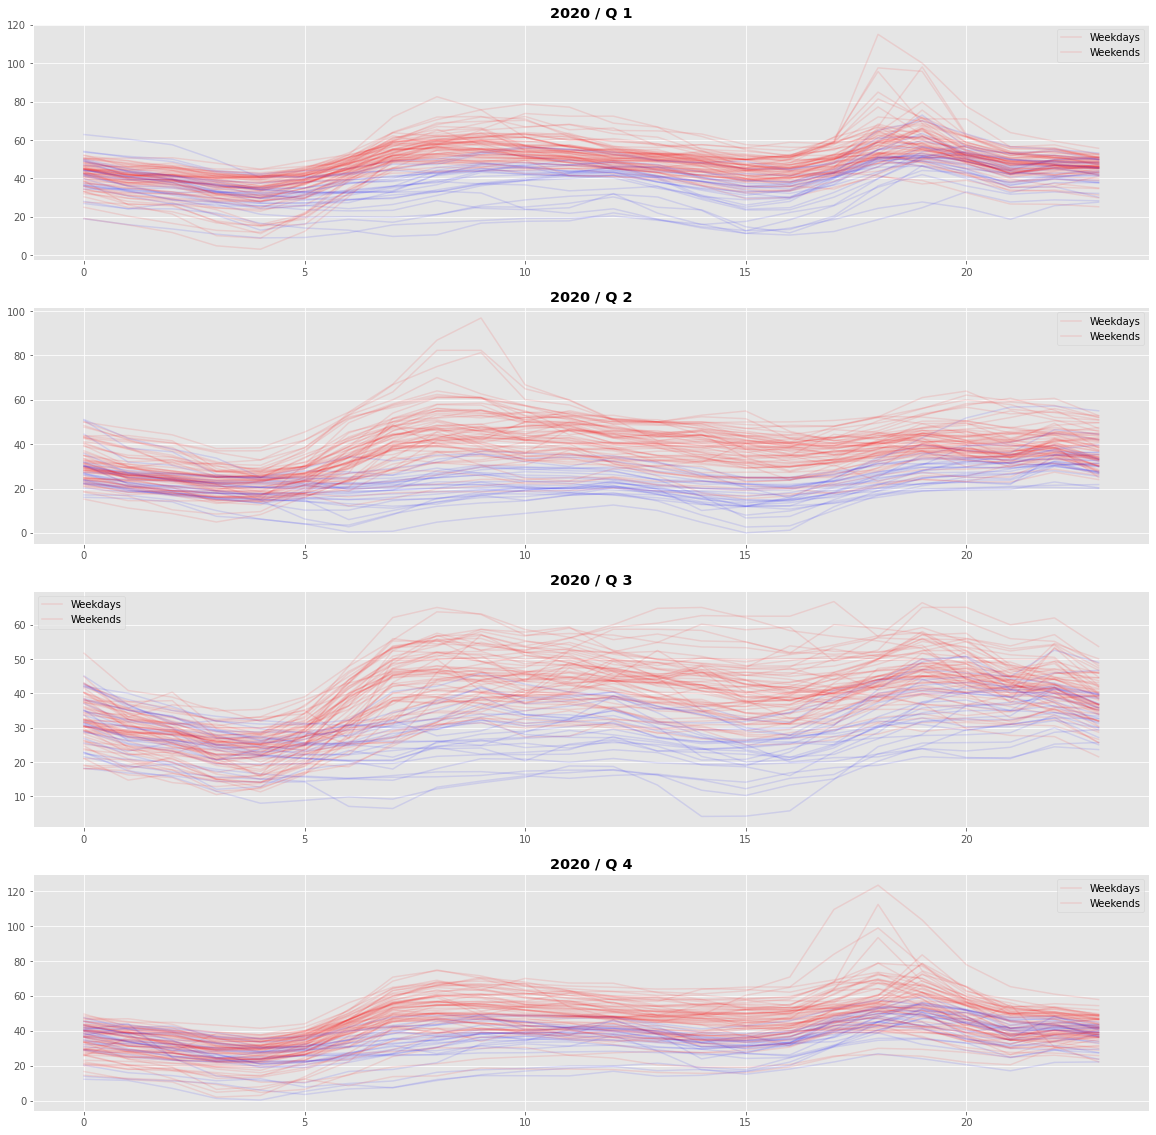

In [6]:
y2015 = years['2015']
f, axes = plt.subplots(len(y2015['date'].dt.quarter.unique()), 1, figsize = (20,20))
axes = axes.flatten()

for quarter in y2015['date'].dt.quarter.unique(): 
    sub_quarter = y2015[y2015['date'].dt.quarter == quarter]
    for m in sub_quarter['date'].dt.month.unique(): 
        sub_month = sub_quarter[sub_quarter['date'].dt.month == m]
        for w in sub_month['date'].dt.isocalendar().week.unique(): 
            sub_week = sub_month[sub_month['date'].dt.isocalendar().week == w]
            for d in sub_week['date'].dt.day.unique(): 
                sub_day = sub_week[sub_week['date'].dt.day == d]
                week_day = sub_day['date'].dt.weekday.values[1] < 5
                ax = axes[quarter-1]
                ax.plot(sub_day.price.values.flatten(), alpha = 0.1, color = 'red' if week_day else 'blue')
                ax.set_title('{} / Q {}'.format(k, quarter), weight = 'bold')
                ax.legend(['Weekdays', 'Weekends'])

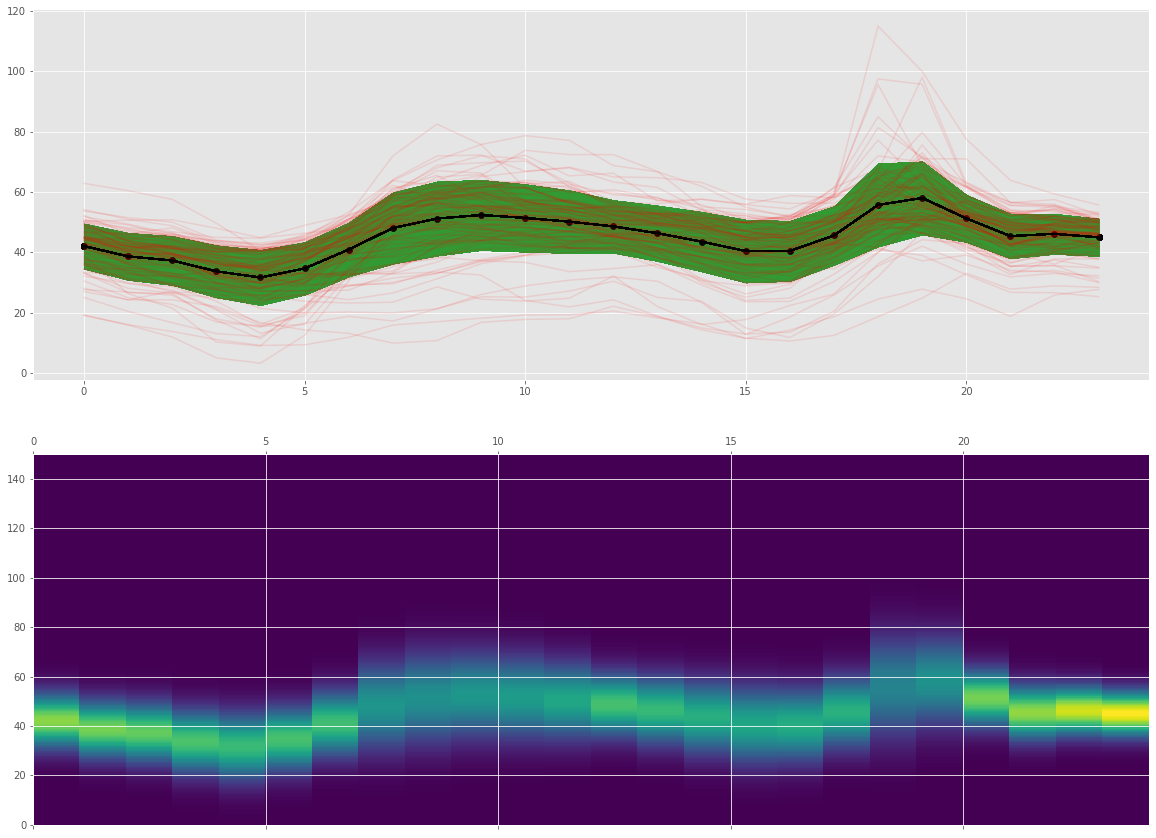

In [7]:
q1 = y2015[y2015['date'].dt.quarter == 1]
daily_prices= []
for m in q1['date'].dt.month.unique(): 
    sub_m = q1[q1['date'].dt.month == m]
    for w in sub_m['date'].dt.isocalendar().week.unique():
        sub_w = sub_m[sub_m['date'].dt.isocalendar().week == w]
        for d in sub_w['date'].dt.weekday.unique(): 
            day = sub_w[sub_w['date'].dt.weekday == d]
            daily_prices.append(day.price.values.flatten())
daily_prices = np.array(daily_prices)
daily_means = np.mean(daily_prices, axis = 0).flatten()
daily_stds = np.std(daily_prices, axis = 0).flatten()
dists = [stats.norm(loc = m, scale = s) for m,s in zip(daily_means, 
                                                       daily_stds)]
#probs = np.hstack([np.flipud(dist.pdf(np.linspace(0,150., 300)).reshape(-1,1)) for dist in dists])
probs = np.hstack([dist.pdf(np.linspace(0,150., 300)).reshape(-1,1)[::-1,:] for dist in dists])

f, axes = plt.subplots(2,1, figsize = (20,15))
axes = axes.flatten()
for p in daily_prices: 
    axes[0].fill_between(np.arange(daily_means.shape[0]),y1=  daily_means - daily_stds, 
                                                         y2 = daily_means + daily_stds, 
                                                         color = (0.2,0.6,0.2), alpha = 0.5)
    axes[0].plot(daily_means, color = 'k')
    axes[0].scatter(np.arange(daily_means.shape[0]), daily_means, color = 'k')
    axes[0].plot(p, alpha = 0.1, color = 'red')
    
    
axes[1].matshow(probs, extent = (0,24,0,150), aspect = 'auto')

date  wind_speed  wind_speed.1  roughness_length  temperature
1 2015-01-01 00:00:00    3.600401      5.867459          0.217649   275.851943
2 2015-01-01 01:00:00    3.190355      5.072264          0.217660   275.566764
3 2015-01-01 02:00:00    2.762125      4.310045          0.217681   275.078314
4 2015-01-01 03:00:00    2.584416      3.844975          0.217737   274.661537
5 2015-01-01 04:00:00    2.498732      3.737150          0.217840   274.656185

### Recap function that generates data based on the hourly normal parameters per quarter

In [9]:
def sample_data(initial_df, target_col, target_year = 2015, smoothing_filter_size = 4):
    yearly_data = initial_df[initial_df['date'].dt.year == target_year]
    per_quarter_value = []
    
    for q in yearly_data['date'].dt.quarter.unique(): 
        daily_data = []
        sub_quarter = yearly_data[yearly_data['date'].dt.quarter == q]
        for m in sub_quarter['date'].dt.month.unique(): 
            sub_m = sub_quarter[sub_quarter['date'].dt.month == m]
            for w in sub_m['date'].dt.isocalendar().week.unique():
                sub_w = sub_m[sub_m['date'].dt.isocalendar().week == w]
                for d in sub_w['date'].dt.weekday.unique(): 
                    day = sub_w[sub_w['date'].dt.weekday == d]
                    daily_data.append(day[target_col].values.flatten())
        per_quarter_value.append(np.array(daily_data))
    
    quarterly_samples = []
    for q in per_quarter_value: 
    
        epsi = np.random.normal(0.,0.3, size = (7 * 13, 24))
        means = np.mean(q, axis = 0)
        stds = np.std(q, axis = 0)
        
        samples = means.reshape(1,-1) + epsi * stds.reshape(1,-1)
        smoothed_samples = np.convolve(samples.flatten(),
                                       np.ones(smoothing_filter_size,) / float(smoothing_filter_size), 
                                      mode= 'same') 
                
        quarterly_samples.append(smoothed_samples.flatten())
    return quarterly_samples

# ONE YEAR OF PROD
sampled_prod = sample_data(prod, 'wind_speed')
# ONE YEAR OF CONSUMPTION
sampled_consumption = sample_data(prices, 'price')


In [10]:
prod_data = np.hstack([p.flatten() for p in sampled_prod]).reshape(-1,1)
conso_data = np.hstack([p.flatten() for p in sampled_consumption]).reshape(-1,1)
data = pd.DataFrame(np.hstack([prod_data, conso_data]),
             columns = ['prod', 'conso'])
data['date'] = pd.to_datetime(pd.date_range("2015", freq = "H", periods = len(data)))
data.to_csv('./sampled_data.csv', index = False)

### ENV CREATION PROCESS

In [13]:
data = pd.read_csv('sampled_data.csv')
data['date'] = pd.to_datetime(data['date'])

In [15]:
look_back = 3
data = data[['date', 'prod', 'conso']]
rl_data = data[['date']]

# ADDING LOOKBACK
for i in range(look_back): 
    rl_data['prod_s{}'.format(i)] = data['prod'].shift(i)
    rl_data['conso_s{}'.format(i)] = data['conso'].shift(i)


# ADDING TRENDS 
periods = [3, 5, 10, 20]
for ip, period in enumerate(periods): 
    for col in ['prod', 'conso']: 
        indicator = ta.trend.SMAIndicator(rl_data['{}_s0'.format(col)], window = period)
        sma = indicator.sma_indicator()
        
        for c in rl_data.columns: 
            if c in ['{}_s{}'.format(col, i) for i in range(look_back)]: 
                rl_data['{}_{}n'.format(c, period)] = rl_data[c] / sma -1.
        
# ADDING NORMALIZED TIME
rl_data['hour_n'] = rl_data['date'].dt.hour / 24.
rl_data['day_n'] = rl_data['date'].dt.weekday / 6.

# ADDING UNSCALED COLS 
rl_data['conso'] = data['conso']
rl_data['prod'] = data['prod']


# CLEANING
rl_data.dropna(inplace = True)
rl_data.reset_index(drop = True, inplace = True)



# OUTPUT 
rl_data.to_csv('rl_s3same_env.csv', index = False)

# INSPECTION
rl_data.head()

<ipython-input-15-fe3009c13a1a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rl_data['prod_s{}'.format(i)] = data['prod'].shift(i)


date   prod_s0   conso_s0   prod_s1   conso_s1   prod_s2  \
0 2015-01-01 19:00:00  5.780344  54.243709  6.288196  50.223800  6.412112   
1 2015-01-01 20:00:00  5.785440  54.264293  5.780344  54.243709  6.288196   
2 2015-01-01 21:00:00  5.871731  52.089275  5.785440  54.264293  5.780344   
3 2015-01-01 22:00:00  5.830009  46.198327  5.871731  52.089275  5.785440   
4 2015-01-01 23:00:00  6.157004  42.647225  5.830009  46.198327  5.871731   

    conso_s2  prod_s0_3n  prod_s1_3n  prod_s2_3n  ...  prod_s0_20n  \
0  43.957231   -0.061666    0.020775    0.040891  ...     0.052501   
1  50.223800   -0.027874   -0.028730    0.056604  ...     0.024738   
2  54.243709    0.010189   -0.004656   -0.005533  ...     0.021624   
3  54.264293    0.000163    0.007320   -0.007483  ...     0.006102   
4  52.089275    0.034284   -0.020646   -0.013638  ...     0.050684   

   prod_s1_20n  prod_s2_20n  conso_s0_20n  conso_s1_20n  conso_s2_20n  \
0     0.144972     0.167535      0.304283      0.207625      0.056946   
1     0.023835     0.113788      0.252611      0.252136      0.159342   
2     0.006610     0.005723      0.170900      0.219791      0.219328   
3     0.013302    -0.001589      0.027147      0.158123      0.206481   
4    -0.005117     0.002003     -0.060333      0.017910      0.147708   

     hour_n  day_n      conso      prod  
0  0.791667    0.5  54.243709  5.780344  
1  0.833333    0.5  54.264293  5.785440  
2  0.875000    0.5  52.089275  5.871731  
3  0.916667    0.5  46.198327  5.830009  
4  0.958333    0.5  42.647225  6.157004  

[5 rows x 35 columns]

In [ ]:
rl_data.columns

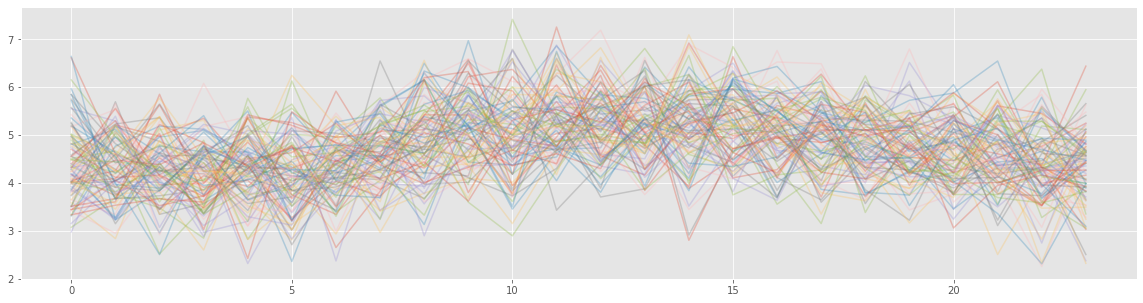

In [37]:
sampled_conso_data = np.random.normal(0.,0.3, size = (7 * 13, 24)) * daily_stds.reshape(1,-1) + daily_means.reshape(1,-1)
plt.figure(figsize = (20,5))
for p in sampled_conso_data: 
    plt.plot(p, alpha = 0.3)

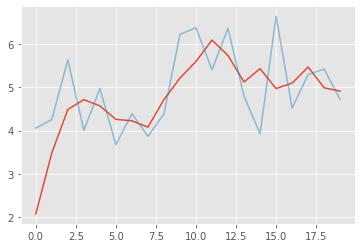

In [61]:
smoothed = np.convolve(sampled_conso_data.flatten(), np.ones(4,)* 0.25, mode = 'same')

#smoothed = np.convolve(np.ones((4,), sampled_conso_data.flatten()) * 0.25, mode = 'same')
smoothed.shape
plt.plot(smoothed[:20])
plt.plot(sampled_conso_data.flatten()[:20], alpha = 0.5)

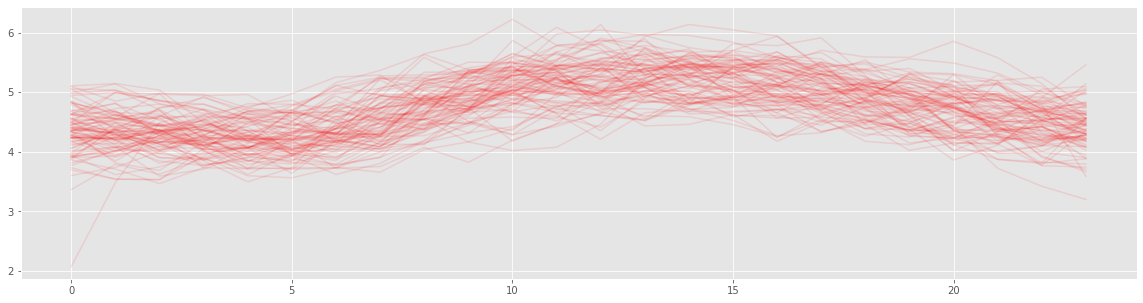

In [65]:
plt.figure(figsize = (20,5))
for p in smoothed.reshape(-1,24): 
    plt.plot(p, alpha = 0.1, color = 'red')

In [13]:
prod = pd.read_csv('weather.csv')
prod.drop(0, axis =0, inplace = True)
c = list(prod.columns) 
c[0] = 'date'
prod.columns = c
prod['date'] = pd.to_datetime(prod['date'])
prod.head()

date  wind_speed  wind_speed.1  roughness_length  temperature
1 2015-01-01 00:00:00    3.600401      5.867459          0.217649   275.851943
2 2015-01-01 01:00:00    3.190355      5.072264          0.217660   275.566764
3 2015-01-01 02:00:00    2.762125      4.310045          0.217681   275.078314
4 2015-01-01 03:00:00    2.584416      3.844975          0.217737   274.661537
5 2015-01-01 04:00:00    2.498732      3.737150          0.217840   274.656185

In [15]:
prod_years = [prod[prod['date'].dt.year == y] for y in prod['date'].dt.year.unique()]

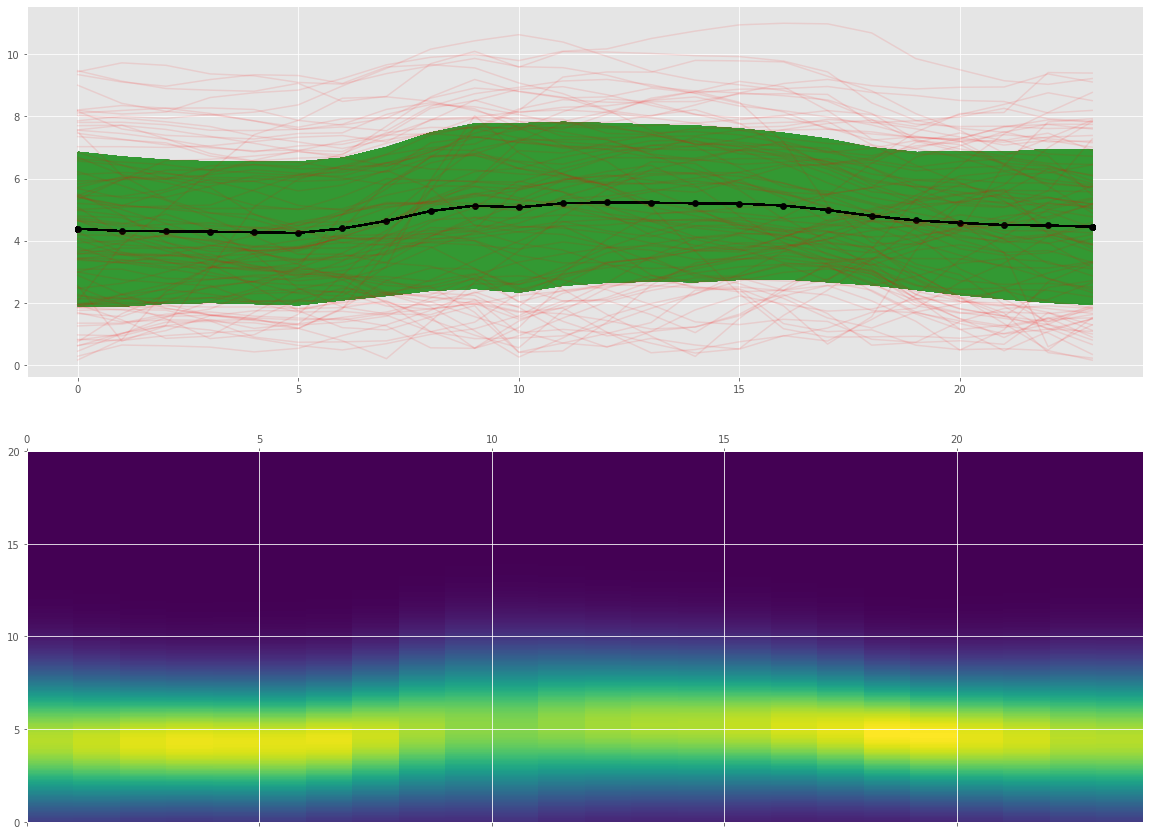

In [28]:
y2015 = prod_years[0]
q1 = y2015[y2015['date'].dt.quarter == 3]
daily_speed= []
for m in q1['date'].dt.month.unique(): 
    sub_m = q1[q1['date'].dt.month == m]
    for w in sub_m['date'].dt.isocalendar().week.unique():
        sub_w = sub_m[sub_m['date'].dt.isocalendar().week == w]
        for d in sub_w['date'].dt.weekday.unique(): 
            day = sub_w[sub_w['date'].dt.weekday == d]
            daily_speed.append(day.wind_speed.values.flatten())
daily_speed = np.array(daily_speed)
daily_means = np.mean(daily_speed, axis = 0).flatten()
daily_stds = np.std(daily_speed, axis = 0).flatten()
dists = [stats.norm(loc = m, scale = s) for m,s in zip(daily_means, 
                                                       daily_stds)]

probs = np.hstack([dist.pdf(np.linspace(0,20., 300)).reshape(-1,1)[::-1,:] for dist in dists])

f, axes = plt.subplots(2,1, figsize = (20,15))
axes = axes.flatten()
for p in daily_speed: 
    axes[0].fill_between(np.arange(daily_means.shape[0]),y1=  daily_means - daily_stds, 
                                                         y2 = daily_means + daily_stds, 
                                                         color = (0.2,0.6,0.2), alpha = 0.5)
    axes[0].plot(daily_means, color = 'k')
    axes[0].scatter(np.arange(daily_means.shape[0]), daily_means, color = 'k')
    axes[0].plot(p, alpha = 0.1, color = 'red')
    
    
axes[1].matshow(probs, extent = (0,24,0,20), aspect = 'auto')

In [22]:
daily_means[0], np.mean(daily_speed[:,0])

(5.706424924222999, 5.706424924223)